### Import Necessary Packages

In [14]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sagemaker 
import boto3 
from sklearn import preprocessing, metrics
import gc
import os
import pandas as pd 

### Get xgboost 1.0-1 container 

In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '1.0-1')
container 

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

### Produce SageMaker s3_input object

In [7]:
prefix = 'demand-prediction'
bucket = sagemaker.Session().default_bucket()

s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
(s3_input_train, s3_input_validation)

(<sagemaker.inputs.TrainingInput at 0x7fdbb8b96080>,
 <sagemaker.inputs.TrainingInput at 0x7fdbb8b961d0>)

### Training

In [8]:
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        num_round=20)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-11-18 06:20:56 Starting - Starting the training job...
2020-11-18 06:20:58 Starting - Launching requested ML instances......
2020-11-18 06:22:11 Starting - Preparing the instances for training......
2020-11-18 06:23:16 Downloading - Downloading input data......
2020-11-18 06:24:02 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','

2020-11-18 06:24:29 Training - Training image download completed. Training in progress.[06:24:42] 5655000x33 matrix with 184896885 entries loaded from /opt

### Deploy the Inference Endpoint

In [11]:
from sagemaker.serializers import CSVSerializer
serializer=CSVSerializer()
xgb_predictor = xgb.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1, serializer=CSVSerializer())

-----------------------!

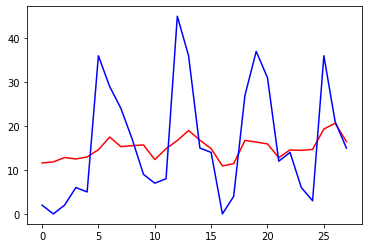

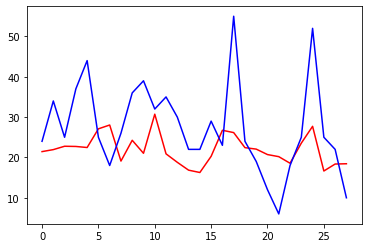

In [16]:
def to_csv(aryarray):
    result = ''
    for aa in aryarray:
        result += ",".join(aa.astype("str").tolist()) +'\n'
    return result 
        

def predict(data, model):
    return model.predict(to_csv(data)).decode('utf-8')

features = ['demand', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', 'rolling_kurt_t30']

validation = pd.read_csv('test.csv', names=features) 

## Generate predictions on the test set for the difference models
import matplotlib.pyplot as plt
def plot_result(item, store): 
    data = validation[(validation['item_id']==item) & (validation['store_id']==store)]
    predictions = predict(data.values[:,1:], xgb_predictor)
    predictions = np.array(predictions.split(",")).astype('float')
    x = range(0, len(predictions))
    fig = plt.figure()
    plt.plot(x, predictions, color='red')
    plt.plot(x, data['demand'].values, color='blue')

plot_result(114, 8)    
plot_result(294, 6)
